In [1]:
from helper import *
from ImportLib import *
from plot import *
from LisenceAPI import *

In [2]:
def LicenseMatcher(InputImage):
    MIN_MATCH_COUNT = 2
    detector=cv2.xfeatures2d.SIFT_create()

    FLANN_INDEX_KDITREE = 0
    flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
    flann=cv2.FlannBasedMatcher(flannParam,{})

    trainImg=cv2.imread("REF_LICENSE.jpg",0)
    trainKP,trainDesc=detector.detectAndCompute(trainImg,None)

    QueryImgBGR = InputImage
    QueryImgBGR = increase_brightness(QueryImgBGR, value=60)
    QueryImg=cv2.cvtColor(QueryImgBGR,cv2.COLOR_BGR2GRAY)

    queryKP,queryDesc = detector.detectAndCompute(QueryImg,None)
    matches           = flann.knnMatch(queryDesc,trainDesc,k=2)
    goodMatch         = []

    for m,n in matches:
        if(m.distance<0.75*n.distance):
            goodMatch.append(m)

    if(len(goodMatch)>MIN_MATCH_COUNT):
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        x_points=[]
        y_points=[]
        for border in queryBorder[0]:
            x_points.append(border[0])
            y_points.append(border[1])

        x_start=int(min(x_points))
        y_start=int(min(y_points))
        x_end=int(max(x_points))
        y_end=int(max(y_points))
        warped=QueryImgBGR[y_start:y_end,x_start:x_end]

    else:
        raise Exception('Not Enough match found,Make sure its an License Card and recapture the image again')
        
    Edged = four_point_transform(QueryImgBGR, queryBorder.reshape(4, 2))
    
    return Edged

In [3]:
def LicenseCutter(InputImage,CutLimit=0):
    Kernel = np.ones((2,2), np.uint8)
    Kernel_sharpen    = np.array([[-1,-1,-1], [-1, 9,-1],[-1,-1,-1]])
    Kernel_Vertical   = np.ones((2,1), np.uint8)
    Kernel_Horizontal = np.ones((1,2), np.uint8)

    InputEdgedImage = LicenseMatcher(InputImage)
    Edged_Resized = cv2.resize(InputEdgedImage,(1600,990))
    Edged_Gray = cv2.cvtColor(Edged_Resized, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    Edged_Gray = clahe.apply(Edged_Gray)

    if CutLimit == 0:
        Num = Edged_Gray[235:325,110:340]
        Let = Edged_Gray[240:330,370:635]
    elif CutLimit ==1:
        Num = Edged_Gray[280:390,110:340]
        Let = Edged_Gray[280:390,370:635]

    ret,NumBIN  = cv2.threshold(Num,120,160,cv2.THRESH_BINARY)
    NumBIN   = cv2.dilate(NumBIN,Kernel,iterations=2)
    NumBIN   = cv2.erode(NumBIN,Kernel,iterations=1)

    ret,NumOTSU = cv2.threshold(Num,160,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    NumOTSU   = cv2.dilate(NumBIN,Kernel,iterations=1)
    NumOTSU   = cv2.erode(NumBIN,Kernel,iterations=1)

    ret,LetBIN  = cv2.threshold(Let,120,160,cv2.THRESH_BINARY)
    LetBIN   = cv2.dilate(LetBIN,Kernel,iterations=2)
    LetBIN   = cv2.erode(LetBIN,Kernel,iterations=1)

    ret,LetOTSU = cv2.threshold(Let,160,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    LetOTSU   = cv2.dilate(LetOTSU,Kernel,iterations=2)
    LetOTSU   = cv2.erode(LetOTSU,Kernel,iterations=1)

    Let   = cv2.dilate(Let,Kernel_Vertical,iterations=3)
    Let   = cv2.dilate(Let,Kernel_Horizontal,iterations=3)
    Let   = cv2.erode(Let,Kernel,iterations=2)
    
    return NumBIN,NumOTSU,LetOTSU,LetBIN

In [4]:
def LettersDetection(LetBIN,LetOTSU):
    config = "-l  fas-tune-float --oem 1 --psm 6"

    LettersBinary = pytesseract.image_to_string(LetBIN,config=config) 
    LettersOTSU   = pytesseract.image_to_string(LetOTSU,config=config)

    if len(LettersBinary)==0 and  0 < len(LettersOTSU) < 4:
        Letters = LettersOTSU
    elif len(LettersOTSU)==0 and 0 < len(LettersBinary) < 4:
        Letters = LettersBinary
    else:
        if  0 < len(LettersBinary) < 4  and len(LettersOTSU) > 4:
            Letters = LettersBinary
        else:
            Letters = LettersOTSU

    return Letters

def NumbersDetection(NumBIN,NumOTSU):
    
    NumbersBinary = pytesseract.image_to_string(NumBIN,lang='ara_number') 
    NumbersOTSU   = pytesseract.image_to_string(NumOTSU,lang='ara_number')


    if len(NumbersBinary)==0 and len(NumbersOTSU)!=0:
        Numbers = NumbersOTSU
    elif len(NumbersOTSU)==0 and len(NumbersBinary)!=0:
        Numbers = NumbersBinary
    else:
        if len(NumbersBinary)==0 and len(NumbersOTSU)==0:
            Numbers = ''
        else:
            Numbers = min(int(NumbersBinary,10),int(NumbersOTSU,10))
            Numbers = str(Numbers)

    return Numbers

In [6]:
def ParseLetters(Letters):
    Letters = Letters.replace("|","")
    Letters = Letters.replace(" ","")
    Letters = Letters.replace('\n','')
    Letters = Letters.replace('۵','ه')
    Letters = Letters.replace('٥','ه')
    Letters = Letters.replace(" ","")
    Letters = re.sub(r'[^\w]', '', Letters)
    if len(Letters) == 1:
        Char1 = ''
        Char2 = ''
        Char3 = ''
    elif len(Letters)==2:
        Char1 = Letters[0]
        Char2 = Letters[1]
        Char3 = ''
    elif len(Letters)==3:
        Char1 = Letters[0]
        Char2 = Letters[1]
        Char3 = Letters[2]
    else:
        Char1,Char2,Char3 = '','',''
    return Char1,Char2,Char3

def ParseNumbers(Numbers):
    Numbers = Numbers.replace(' ','')
    Numbers = Numbers.replace('\n','')
    Numbers = re.sub(r'[^\w]', ' ', Numbers)
    return Numbers

In [7]:
def LicenseFines(InputImage):
    NumBIN,NumOTSU,LetOTSU,LetBIN = LicenseCutter(InputImage,CutLimit=0)
    Char1,Char2,Char3 = ParseLetters(LettersDetection(LetBIN,LetOTSU))    
    Numbers           = ParseNumbers(NumbersDetection(NumBIN,NumOTSU))
    
    if len(Char1)+len(Char2)+len(Char3) == 0:
        NumBIN,NumOTSU,LetOTSU,LetBIN = LicenseCutter(InputImage,CutLimit=1)
        Char1,Char2,Char3 = ParseLetters(LettersDetection(LetBIN,LetOTSU))    
        Numbers           = ParseNumbers(NumbersDetection(NumBIN,NumOTSU))
        
    link = "https://www.egypt.gov.eg/mobile/Services/NTPMOJ-GG/functions/PayFines.aspx"
    Char1,Char2,Char3 = Char1,Char2,Char3
    Num = Numbers
    print(Char1,Char2,Char3)
    print(Numbers)
    Fines = GetFines(link,Char1,Char2,Char3,Num)
    return Fines

ل ف ه
485
505.00 جنيها


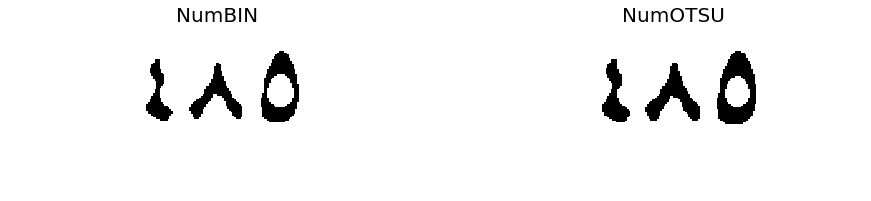

In [10]:
Image = cv2.imread('Lisence_Test/test5.jpg')
print(LicenseFines(Image))